In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import lib_read_HiPSTAR as rf
import lib_VTK as vtk
import numpy as np
import matplotlib.pyplot as plt

# wake line

In [3]:
x1 = 1.03134#1.01824 #1.00221
y1 = -1.49182#-1.46994 #-1.43614
x2 = 1.39964#1.20261
y2 = -2.86039#-1.99731
x = np.geomspace(x1, x2)
y = np.geomspace(y1, y2)
z = 0.0

# function

In [4]:
import numpy as np 

def list_eigen(stresses):
    """
    stresses is a list of stress;
    stress is a numpy array of 6 components
    a11, a22, a33, a12, a13, a23
    """
    n = len(stresses)
    eigens = []
    for i in range(n):
        a11 = stresses[i][0]
        a22 = stresses[i][1]
        a33 = stresses[i][2]
        a12 = stresses[i][3]
        a13 = stresses[i][4]
        a23 = stresses[i][5]
        mat = np.asarray[[a11,a12,a13],[a12,a22,a23],[a13,a23,a33]]
        w,_ = np.linalg.eig(mat)
        eigens.append(w)

    return(eigens)

def list_bary(stresses):
    """
    stresses is a list of stress;
    stress is a numpy array of 6 components
    a11, a22, a33, a12, a13, a23
    """
    n = len(stresses)
    eigens = []
    for i in range(n):
        a11 = stresses[i][0]
        a22 = stresses[i][1]
        a33 = stresses[i][2]
        a12 = stresses[i][3]
        a13 = stresses[i][4]
        a23 = stresses[i][5]
        mat = np.asarray[[a11,a12,a13],[a12,a22,a23],[a13,a23,a33]]
        w,_ = np.linalg.eig(mat)
        C1 = mat[0] - mat[1]
        C2 = 2.0*(mat[1] - mat[2])
        C3 = 3.0*mat[2] +1.0
        Cs = np.asarray([C1,C2,C3])
        eigens.append(Cs)

    return(eigens)

def list_bary_cord(stresses):
    """
    stresses is a list of stress;
    stress is a numpy array of 6 components
    a11, a22, a33, a12, a13, a23

    default cord [-1.0,0] [1.0,0] [0.0, sqrt(3)]
    """
    n = len(stresses)
    eigens = []
    x1 = np.asarray([1.0, 0.0])
    x2 = np.asarray([-1.0, 0.0])
    x3 = np.asarray([0.0, 3.0**0.5])

    for i in range(n):
        a11 = stresses[i][0]
        a22 = stresses[i][1]
        a33 = stresses[i][2]
        a12 = stresses[i][3]
        a13 = stresses[i][4]
        a23 = stresses[i][5]
        mat = np.asarray([[a11,a12,a13],[a12,a22,a23],[a13,a23,a33]])
        w,_ = np.linalg.eig(mat)
        w[::-1].sort()
        C1 = w[0] - w[1]
        C2 = 2.0*(w[1] - w[2])
        C3 = 3.0*w[2] +1.0
        x = C1*x1 + C2*x2 + C3*x3
        eigens.append(x)
    eigens = np.asarray(eigens)
    return(eigens)

def bary_bound():

    p0 = [1.0, 0.0]
    p1 = [-1.0, 0.0]
    p2 = [0.0, 3.0**0.5]

    l1 = []
    l2 = []
    l3 = []

    x1 = np.linspace(p0[0], p2[0])
    x2 = np.linspace(p2[0], p1[0])
    x3 = np.linspace(p0[0], p1[0])

    y1 = np.linspace(p0[1], p2[1])
    y2 = np.linspace(p2[1], p1[1])
    y3 = np.linspace(p0[1], p1[1])

    l1.append(x1)
    l1.append(y1)
    l2.append(x2)
    l2.append(y2)
    l3.append(x3)
    l3.append(y3)

    return(l1,l2,l3)

# Hip VTK

In [5]:
# read hipstar data into vtk object, need to output data into .vtk by paraview first!
hip_vtk = vtk.read_VTK_dataset('vtk/LS5TI5.vtk')

In [6]:
#list the vars to be outputed
nvar_source = hip_vtk.GetPointData().GetNumberOfArrays()
print nvar_source
var_list = []
for i in range(nvar_source):
    temp_var = hip_vtk.GetPointData().GetArrayName(i)
#    print i,temp_var
    var_list.append(temp_var)
#lines = [line.rstrip('\n') for line in open('vtk/header.txt')]
#print lines
print var_list

7
['$ \\overline{\\rho}$', '$ \\tau_{11}$', '$ \\tau_{12}$', '$ \\tau_{13}$', '$ \\tau_{22}$', '$ \\tau_{23}$', '$ \\tau_{33}$']


In [7]:
HiP_stress_line = []
for i in range(len(x)):
    pt = [x[i],y[i],z]
    _, data = vtk.extract_VTK_point(hip_vtk,pt)

    # Hipstar uses negative stress convention
    rho = data[0][1][0][0]
    Rxx = -data[1][1][0][0]
    Rxy = -data[2][1][0][0]
    Rxz = -data[3][1][0][0]
    Ryy = -data[4][1][0][0]
    Ryz = -data[5][1][0][0]
    Rzz = -data[6][1][0][0]
    
    tke = 0.5*(Rxx + Ryy + Rzz)

    HiP_stress_line.append(np.asarray([Rxx/2.0/tke-1.0/3.0,Ryy/2.0/tke-1.0/3.0,Rzz/2.0/tke-1.0/3.0,Rxy,Rxz,Ryz]))

In [8]:
HiP_inv_line = list_bary_cord(HiP_stress_line)
print HiP_inv_line.shape

(50, 2)


# Lumley

In [9]:
l1,l2,l3 = bary_bound()

# RANS Baseline

In [10]:
# read hipstar data into vtk object, need to output data into .vtk by paraview first!
baseline_vtk = vtk.read_VTK_dataset('vtk/RANS_baseline.vtk')
#list the vars to be outputed
nvar_source = baseline_vtk.GetPointData().GetNumberOfArrays()
print nvar_source
var_list = []
for i in range(nvar_source):
    temp_var = baseline_vtk.GetPointData().GetArrayName(i)
#    print i,temp_var
    var_list.append(temp_var)
#lines = [line.rstrip('\n') for line in open('vtk/header.txt')]
#print lines
print var_list

13
['Momentum', 'Density', 'Function0', 'Function1', 'Function2', 'Function3', 'Function4', 'Function5', 'Function6', 'Function7', 'Function8', 'Pressure', 'StagnationEnergy']


In [11]:
baseline_stress_line = []
for i in range(len(x)):
    pt = [x[i],y[i],z]
    _, data = vtk.extract_VTK_point(baseline_vtk,pt)

    # Hipstar uses negative stress convention
    rho = data[1][1][0][0]
    tke = data[9][1][0][0]
    Rxx = -data[2][1][0][0]/rho/tke/2.0
    Rxy = -data[3][1][0][0]/rho/tke/2.0
    Ryy = -data[4][1][0][0]/rho/tke/2.0
    Rxz = 0.0
    Ryz = 0.0
    Rzz = -(Rxx + Ryy)

    baseline_stress_line.append(np.asarray([Rxx,Ryy,Rzz,Rxy,Rxz,Ryz]))

In [12]:
baseline_inv_line = list_bary_cord(baseline_stress_line)
print baseline_inv_line.shape

(50, 2)


# GEP Model

In [13]:
# read hipstar data into vtk object, need to output data into .vtk by paraview first!
inloop_vtk = vtk.read_VTK_dataset('vtk/RANS_inloop.vtk')
#list the vars to be outputed
nvar_source = inloop_vtk.GetPointData().GetNumberOfArrays()
print nvar_source
var_list = []
for i in range(nvar_source):
    temp_var = inloop_vtk.GetPointData().GetArrayName(i)
#    print i,temp_var
    var_list.append(temp_var)
#lines = [line.rstrip('\n') for line in open('vtk/header.txt')]
#print lines
print var_list

13
['Momentum', 'Density', 'Function0', 'Function1', 'Function2', 'Function3', 'Function4', 'Function5', 'Function6', 'Function7', 'Function8', 'Pressure', 'StagnationEnergy']


In [14]:
inloop_stress_line = []
for i in range(len(x)):
    pt = [x[i],y[i],z]
    _, data = vtk.extract_VTK_point(inloop_vtk,pt)

    # Hipstar uses negative stress convention
    rho = data[1][1][0][0]
    tke = data[9][1][0][0]
    tau_xx = -data[2][1][0][0]/rho/tke/2.0
    tau_xy = -data[3][1][0][0]/rho/tke/2.0
    tau_yy = -data[4][1][0][0]/rho/tke/2.0
    
    a_xx = data[6][1][0][0]/rho/tke/2.0
    a_xy = data[7][1][0][0]/rho/tke/2.0
    a_yy = data[8][1][0][0]/rho/tke/2.0
    
    Rxx = a_xx + tau_xx 
    Rxy = a_xy + tau_xy 
    Ryy = a_yy + tau_yy 
    #Rxx = tau_xx 
    #Rxy = tau_xy 
    #Ryy = tau_yy 
    Rxz = 0.0
    Ryz = 0.0
    #Rzz = -(Rxx + Ryy)
    Rzz = -(tau_xx + tau_yy)
    #print rho,tke,a_xx
    inloop_stress_line.append(np.asarray([Rxx,Ryy,Rzz,Rxy,Rxz,Ryz]))

In [15]:
inloop_inv_line = list_bary_cord(inloop_stress_line)
print inloop_inv_line.shape

(50, 2)


In [16]:
x1t = -1.0/3.0
y1t = 0.0
x2t = 0.0
y2t = 3.0**0.5
xt = np.linspace(x1t, x2t)
yt = np.linspace(y1t, y2t)

<IPython.core.display.Javascript object>


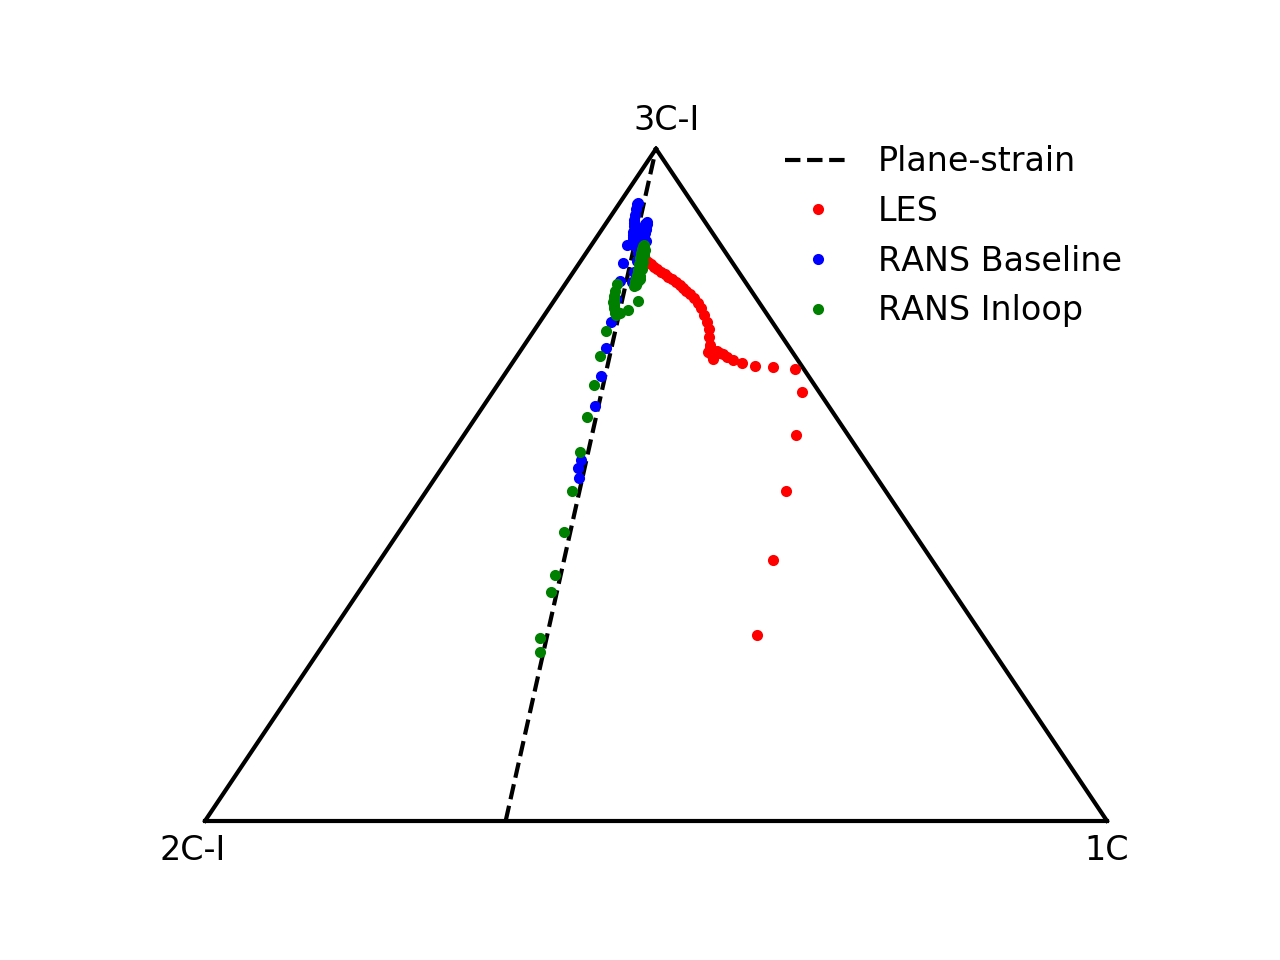

In [17]:
plt.figure()
#plt.axes(aspect='equal')
plt.plot(l1[0],l1[1],'k-')
plt.plot(l2[0],l2[1],'k-')
plt.plot(l3[0],l3[1],'k-')
plt.plot(xt,yt,'k--',label='Plane-strain')
plt.plot(HiP_inv_line[3:,0],HiP_inv_line[3:,1],'ro',markersize=3,label='LES')
plt.plot(baseline_inv_line[3:,0],baseline_inv_line[3:,1],'bo',markersize=3,label='RANS Baseline')
plt.plot(inloop_inv_line[3:,0],inloop_inv_line[3:,1],'go',markersize=3,label='RANS Inloop')
plt.text(-1.1,-0.1,"2C-I",fontsize=12)
plt.text(0.95,-0.1,"1C",fontsize=12)
plt.text(-0.05,1.78,"3C-I",fontsize=12)
plt.legend(frameon=False,fontsize=12)
plt.axis('off')
plt.show()
#plt.savefig('./barycentric_map.png',dpi=400)

<IPython.core.display.Javascript object>


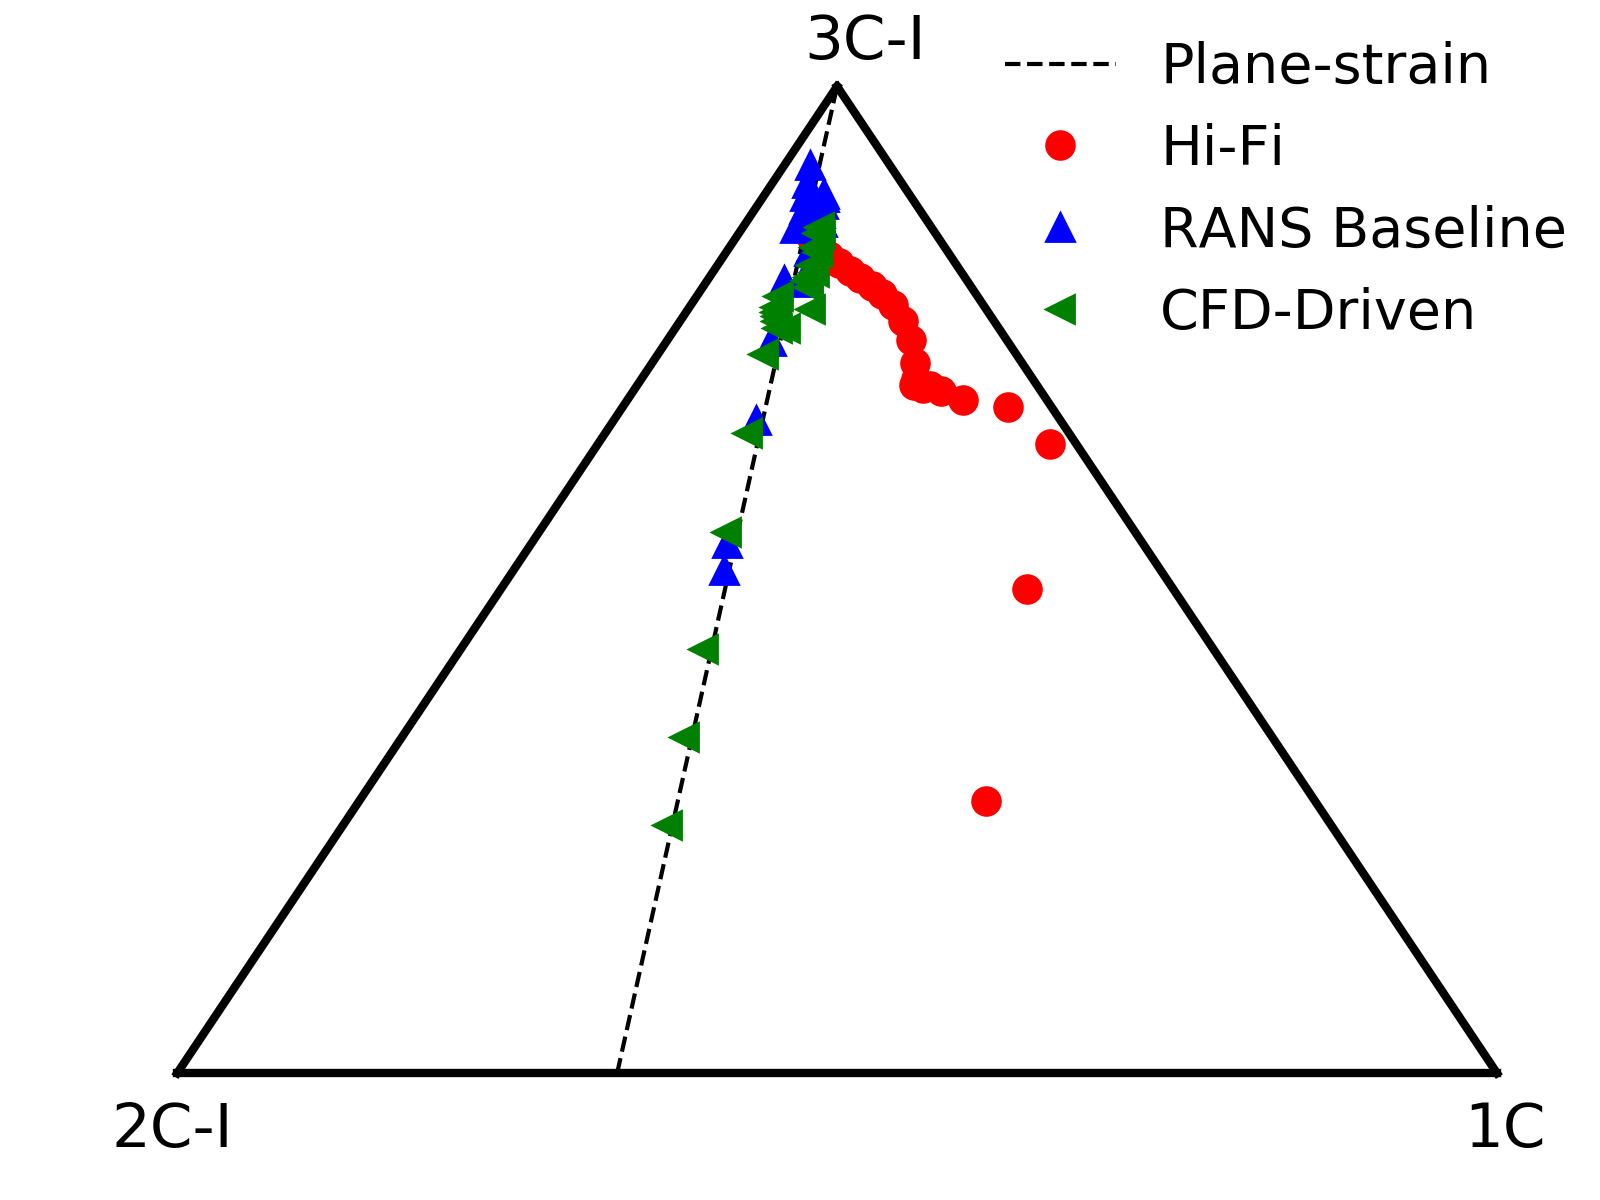

In [20]:
csfont = {'fontname':'Times New Roman'}
plt.figure(figsize=(8,6))
#plt.axes(aspect='equal')
plt.plot(l1[0],l1[1],'k-',linewidth=3.0)
plt.plot(l2[0],l2[1],'k-',linewidth=3.0)
plt.plot(l3[0],l3[1],'k-',linewidth=3.0)
plt.plot(xt,yt,'k--',label='Plane-strain')
plt.plot(HiP_inv_line[3::2,0],HiP_inv_line[3::2,1],'ro',linewidth=3.0,markersize=10,label='Hi-Fi')
plt.plot(baseline_inv_line[3::2,0],baseline_inv_line[3::2,1],'b^',linewidth=3.0,markersize=10,label='RANS Baseline')
plt.plot(inloop_inv_line[3::2,0],inloop_inv_line[3::2,1],'g<',linewidth=3.0,markersize=10,label='CFD-Driven')
plt.text(-1.1,-0.13,"2C-I",fontsize=22,**csfont)
plt.text(0.95,-0.13,"1C",fontsize=22,**csfont)
plt.text(-0.05,1.78,"3C-I",fontsize=22,**csfont)
plt.legend(frameon=False,fontsize=20,loc=[0.6,0.7])
plt.axis('off')
plt.tight_layout()
plt.show()
plt.savefig('./barycentric_map.png',dpi=400)